In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [ ]:
from sklearn.manifold import TSNE
from utils.model_utils import *
from utils.data_utils import *
from utils.inference_utils import *
from utils.extract_utils import *
from utils.prompt_utils import *
import torch
import matplotlib.pyplot as plt

model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
device = 'cuda'

model, tokenizer, model_config = load_model_and_tokenizer(model_name, device=device)
model.eval()
torch.set_grad_enabled(False)

In [37]:
dataset_name = 'banking77'

train_dataset, val_dataset, test_dataset = load_dataset(dataset_name)

prefixes = PREFIX_DICT[dataset_name]
separators = {"input":"\n", "output":"\n\n", "instructions":"\n"}

In [38]:
import numpy as np
from scipy.spatial.distance import pdist, squareform, cdist

def compute_centroid_dist(vectors, metric='cosine'):
    """
    각 벡터가 중심과 얼마나 떨어져 있는지를 평균으로 측정.
    """
    centroid = np.mean(vectors, axis=0, keepdims=True)
    distances = cdist(vectors, centroid, metric=metric)
    return np.mean(distances)

def compute_intra_dist(vectors, metric='cosine'):
    """
    벡터들 간의 평균 거리 계산 (쌍별 거리 평균).
    """
    distances = pdist(vectors, metric=metric)
    return np.mean(distances)

def analyze_vector_sets(vector_sets, metric='cosine'):
    """
    여러 개의 벡터 집합에 대해 밀집도 분석.
    vector_sets: list of np.ndarray, each of shape (n_i, 4096)
    """
    results = []
    for i, vecs in enumerate(vector_sets):
        centroid_dist = compute_centroid_dist(vecs, metric)
        intra_dist = compute_intra_dist(vecs, metric)
        results.append({
            'set_index': i,
            'centroid_dist': centroid_dist,
            'intra_dist': intra_dist
        })
    return results

In [39]:
import matplotlib.pyplot as plt


def plot_normalized_density_results(results):
    indices = [r['set_index'] for r in results]
    centroid_dists = np.array([r['centroid_dist'] for r in results])
    intra_dists = np.array([r['intra_dist'] for r in results])

    # 정규화 (Min-Max)
    all_values = np.concatenate([centroid_dists, intra_dists])
    min_val, max_val = all_values.min(), all_values.max()

    def normalize(x): return (x - min_val) / (max_val - min_val + 1e-8)

    # norm_centroid = normalize(centroid_dists)
    # norm_intra = normalize(intra_dists)
    norm_centroid = centroid_dists
    norm_intra = intra_dists


    x = np.arange(len(results))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, norm_centroid, width, label='CentroidDist (normalized)')
    ax.bar(x + width/2, norm_intra, width, label='IntraDist (normalized)')

    ax.set_ylabel('Normalized Distance (0–1)')
    ax.set_xlabel('Layer Index')
    ax.set_title('Normalized Density Comparison of ICV')
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in indices])
    ax.legend()

    plt.tight_layout()
    plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


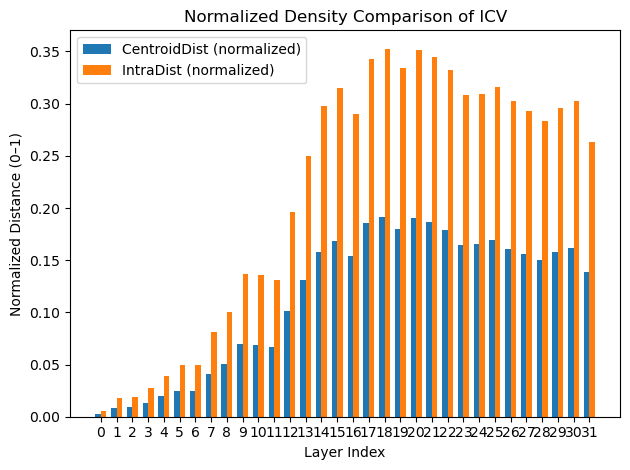

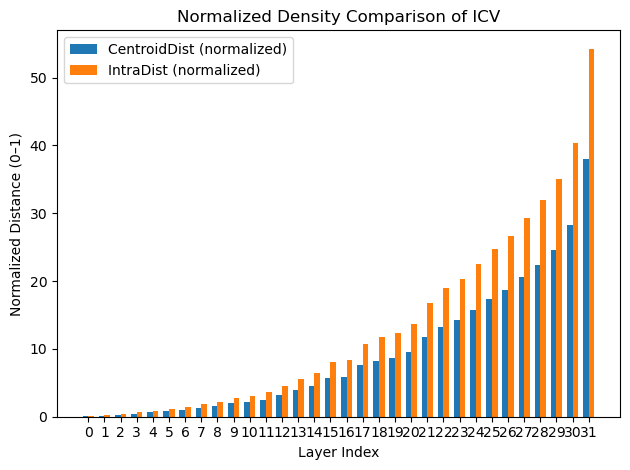

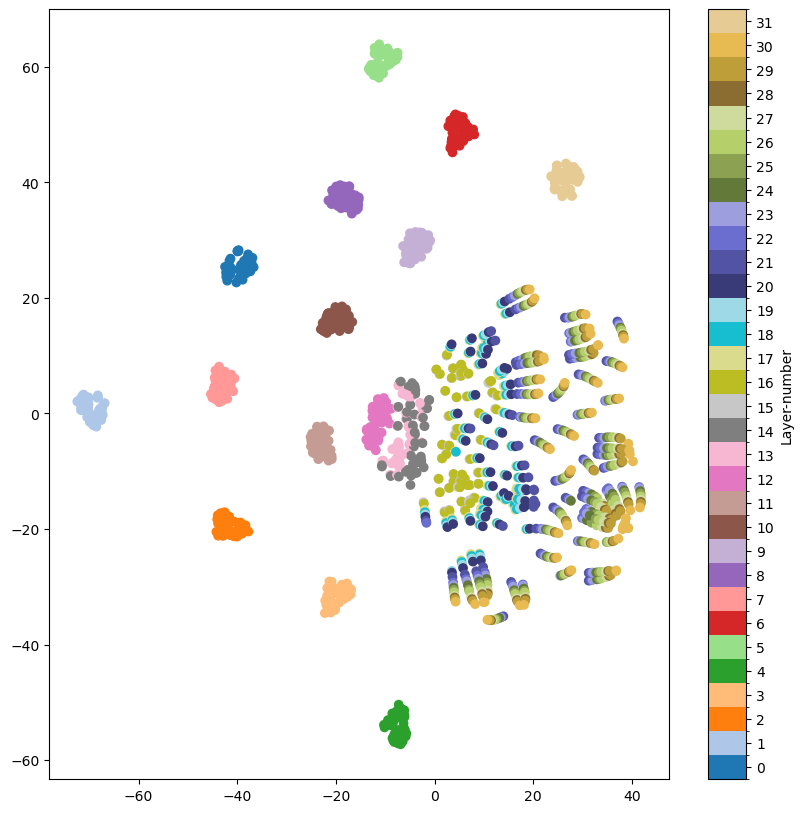

In [40]:
from matplotlib.colors import ListedColormap, BoundaryNorm

icvs = []

N_ITER = 50
for _ in range(N_ITER):
    icv = get_mean_hidden_states(train_dataset=train_dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=100, N_TRIALS=1, prefixes=prefixes, separators=separators, insert_inst=False)
    icvs.append(icv)

divide_by_layer = torch.cat([l.unsqueeze(1) for l in icvs], dim=1)
results_cosine = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='cosine')
results_euclidean = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='euclidean')
plot_normalized_density_results(results_cosine)
plot_normalized_density_results(results_euclidean)

icvs = torch.cat(icvs, dim=0)
icv_labels_by_layer = torch.tensor([i for i in range(32)]*N_ITER)

dim_reduction = TSNE(n_components=2, random_state=42)
icv_2d = dim_reduction.fit_transform(icvs)

plt.figure(figsize=(10, 10))
c = icv_labels_by_layer

colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
discrete_cmap = ListedColormap(colors[:32])
norm = BoundaryNorm(np.arange(-0.5, 32.5, 1), discrete_cmap.N)

scatter = plt.scatter(icv_2d[:, 0], icv_2d[:, 1], c=c, cmap=discrete_cmap, norm=norm)
cbar = plt.colorbar(scatter)
cbar.set_label('Layer-number')  # colorbar 제목
cbar.set_ticks(range(0, 32))  # 0부터 31까지 눈금 추가
cbar.set_ticklabels(range(0, 32))

plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


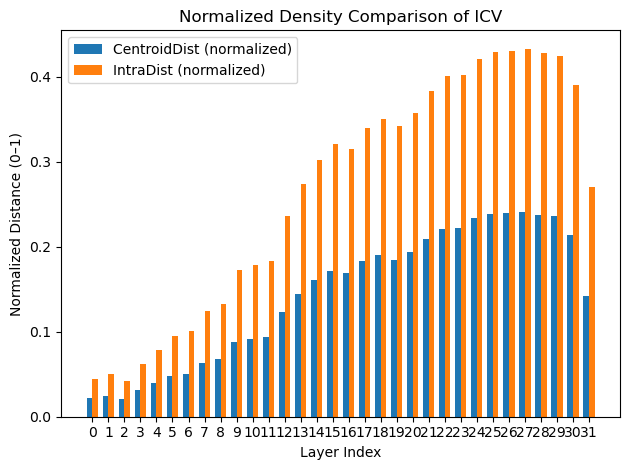

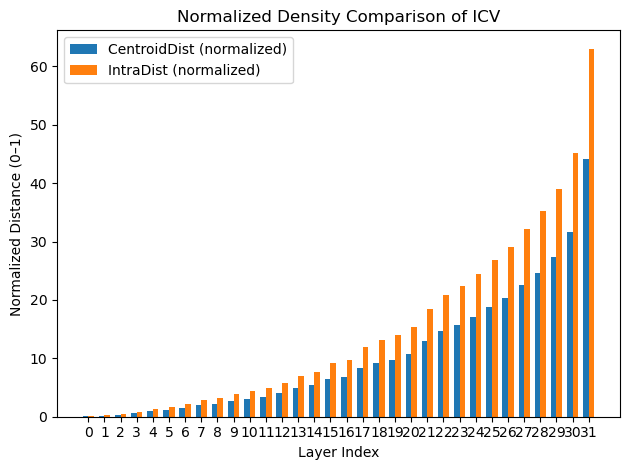

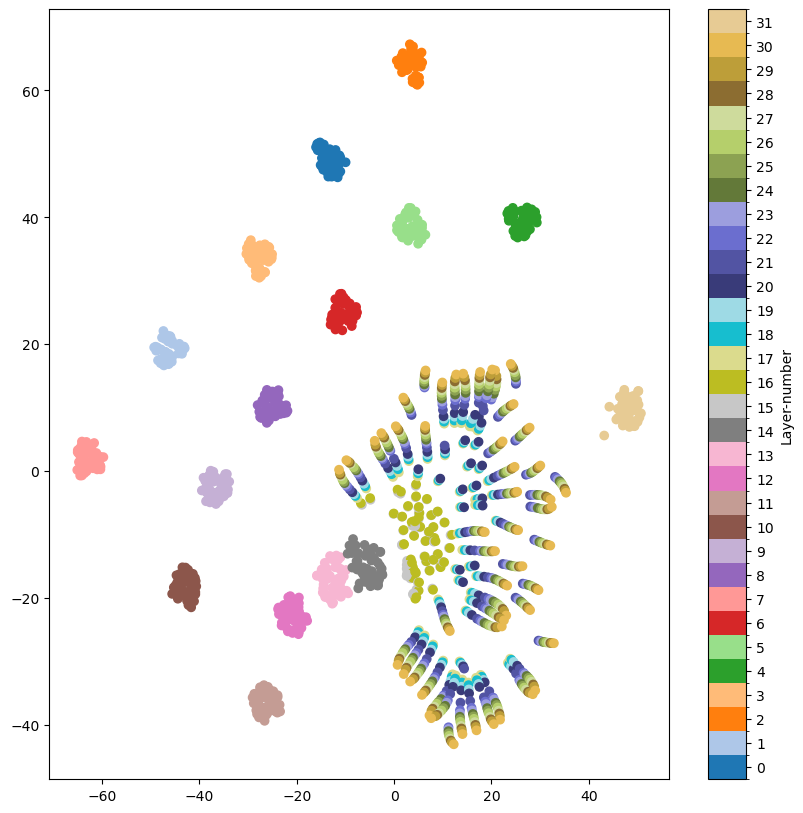

In [41]:
icvs = []

N_ITER = 50
for _ in range(N_ITER):
    icv = get_diff_mean_hidden_states(train_dataset=train_dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=100, N_TRIALS=1, prefixes=prefixes, separators=separators, insert_inst=False)
    icvs.append(icv)

divide_by_layer = torch.cat([l.unsqueeze(1) for l in icvs], dim=1)
results_cosine = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='cosine')
results_euclidean = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='euclidean')
plot_normalized_density_results(results_cosine)
plot_normalized_density_results(results_euclidean)

icvs = torch.cat(icvs, dim=0)
icv_labels_by_layer = torch.tensor([i for i in range(32)]*N_ITER)

dim_reduction = TSNE(n_components=2, random_state=42)
icv_2d = dim_reduction.fit_transform(icvs)

plt.figure(figsize=(10, 10))
c = icv_labels_by_layer

colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
discrete_cmap = ListedColormap(colors[:32])
norm = BoundaryNorm(np.arange(-0.5, 32.5, 1), discrete_cmap.N)

scatter = plt.scatter(icv_2d[:, 0], icv_2d[:, 1], c=c, cmap=discrete_cmap, norm=norm)
cbar = plt.colorbar(scatter)
cbar.set_label('Layer-number')  # colorbar 제목
cbar.set_ticks(range(0, 32))  # 0부터 31까지 눈금 추가
cbar.set_ticklabels(range(0, 32))

plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


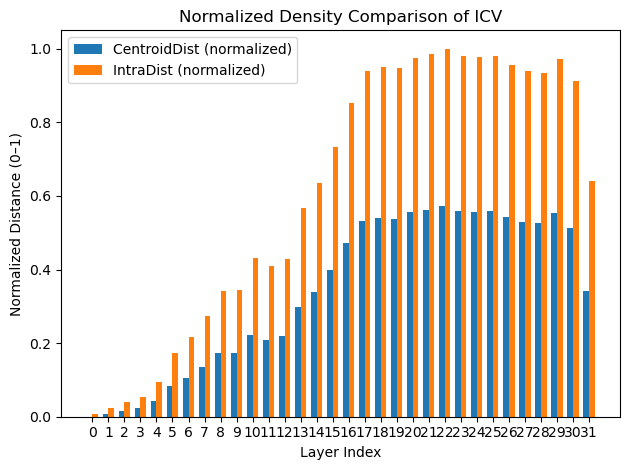

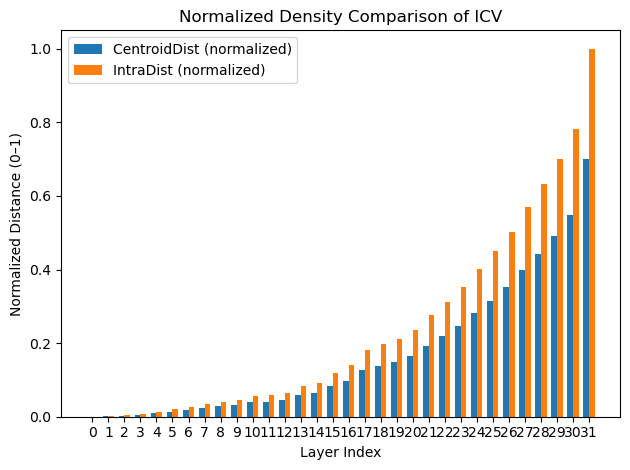

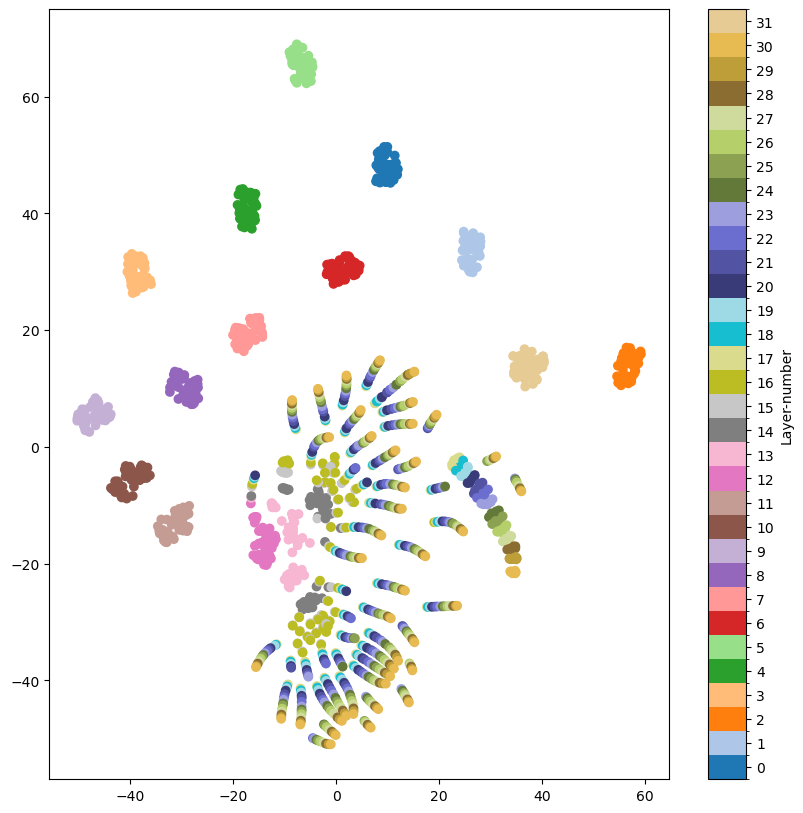

In [34]:
icvs = []

N_ITER = 50
for _ in range(N_ITER):
    icv = get_mean_hidden_states(train_dataset=train_dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=100, N_TRIALS=1, prefixes=prefixes, separators=separators, insert_inst=True)
    icvs.append(icv)

divide_by_layer = torch.cat([l.unsqueeze(1) for l in icvs], dim=1)
results_cosine = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='cosine')
results_euclidean = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='euclidean')
plot_normalized_density_results(results_cosine)
plot_normalized_density_results(results_euclidean)

icvs = torch.cat(icvs, dim=0)
icv_labels_by_layer = torch.tensor([i for i in range(32)]*N_ITER)

dim_reduction = TSNE(n_components=2, random_state=42)
icv_2d = dim_reduction.fit_transform(icvs)

plt.figure(figsize=(10, 10))
c = icv_labels_by_layer

colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
discrete_cmap = ListedColormap(colors[:32])
norm = BoundaryNorm(np.arange(-0.5, 32.5, 1), discrete_cmap.N)

scatter = plt.scatter(icv_2d[:, 0], icv_2d[:, 1], c=c, cmap=discrete_cmap, norm=norm)
cbar = plt.colorbar(scatter)
cbar.set_label('Layer-number')  # colorbar 제목
cbar.set_ticks(range(0, 32))  # 0부터 31까지 눈금 추가
cbar.set_ticklabels(range(0, 32))

plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


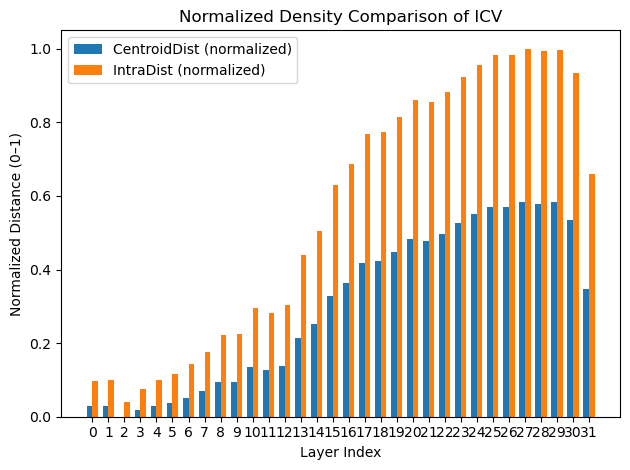

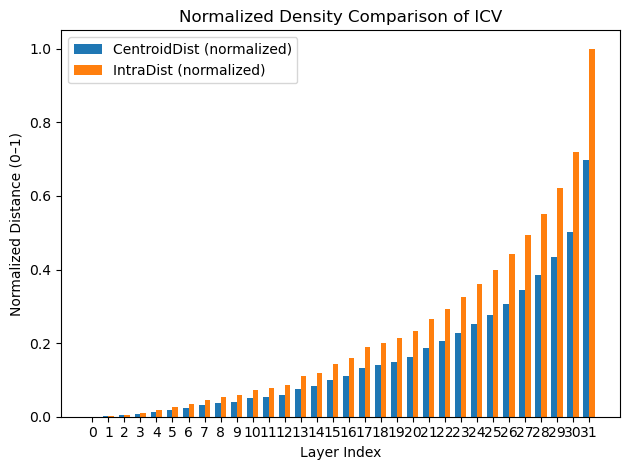

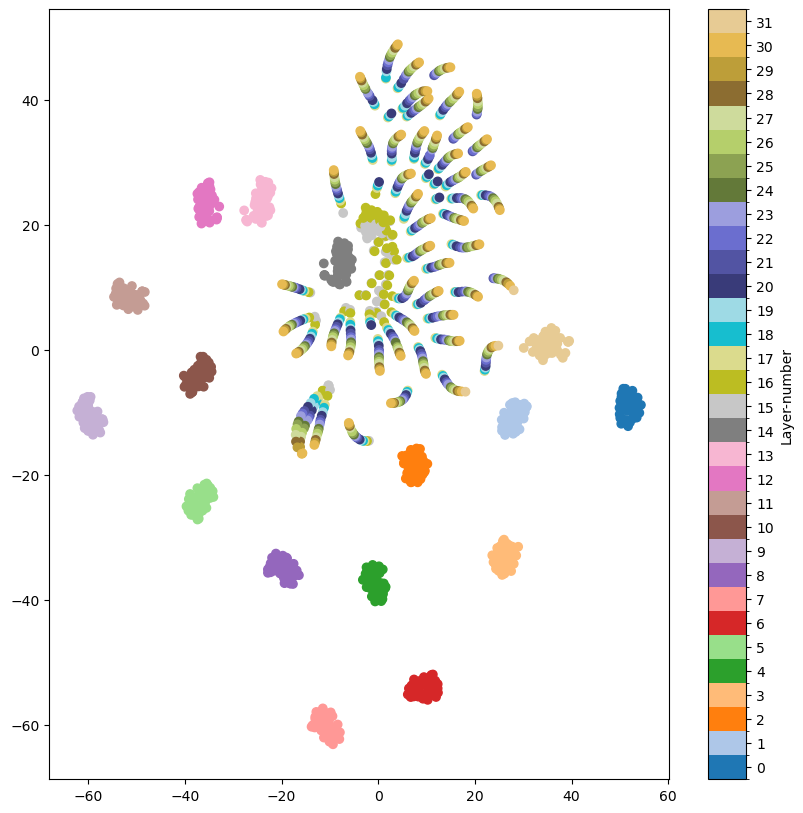

In [35]:
icvs = []

N_ITER = 50
for _ in range(N_ITER):
    icv = get_diff_mean_hidden_states(train_dataset=train_dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=100, N_TRIALS=1, prefixes=prefixes, separators=separators, insert_inst=True)
    icvs.append(icv)

divide_by_layer = torch.cat([l.unsqueeze(1) for l in icvs], dim=1)
results_cosine = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='cosine')
results_euclidean = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='euclidean')
plot_normalized_density_results(results_cosine)
plot_normalized_density_results(results_euclidean)

icvs = torch.cat(icvs, dim=0)
icv_labels_by_layer = torch.tensor([i for i in range(32)]*N_ITER)

dim_reduction = TSNE(n_components=2, random_state=42)
icv_2d = dim_reduction.fit_transform(icvs)

plt.figure(figsize=(10, 10))
c = icv_labels_by_layer

colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
discrete_cmap = ListedColormap(colors[:32])
norm = BoundaryNorm(np.arange(-0.5, 32.5, 1), discrete_cmap.N)

scatter = plt.scatter(icv_2d[:, 0], icv_2d[:, 1], c=c, cmap=discrete_cmap, norm=norm)
cbar = plt.colorbar(scatter)
cbar.set_label('Layer-number')  # colorbar 제목
cbar.set_ticks(range(0, 32))  # 0부터 31까지 눈금 추가
cbar.set_ticklabels(range(0, 32))

plt.show()

100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


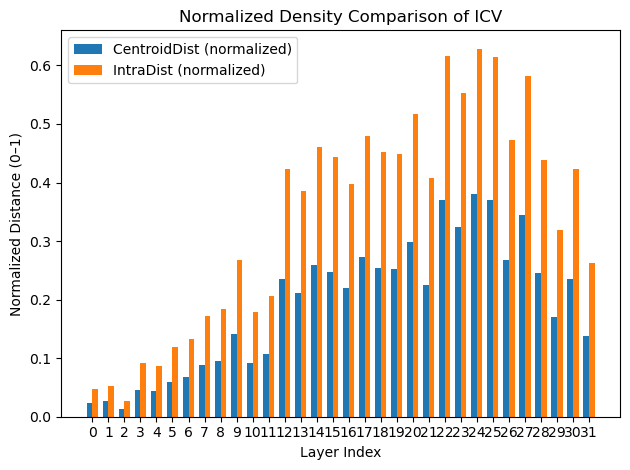

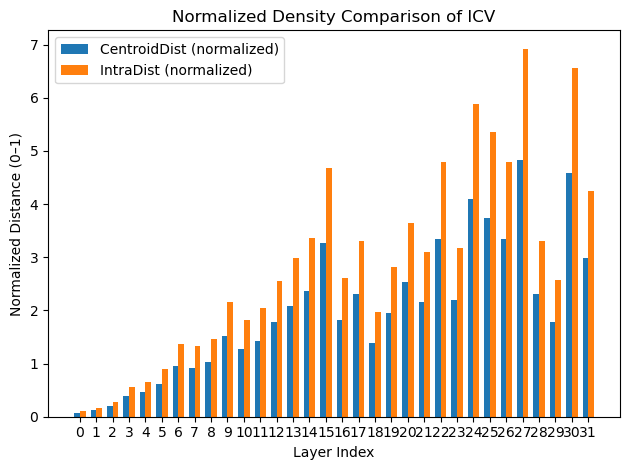

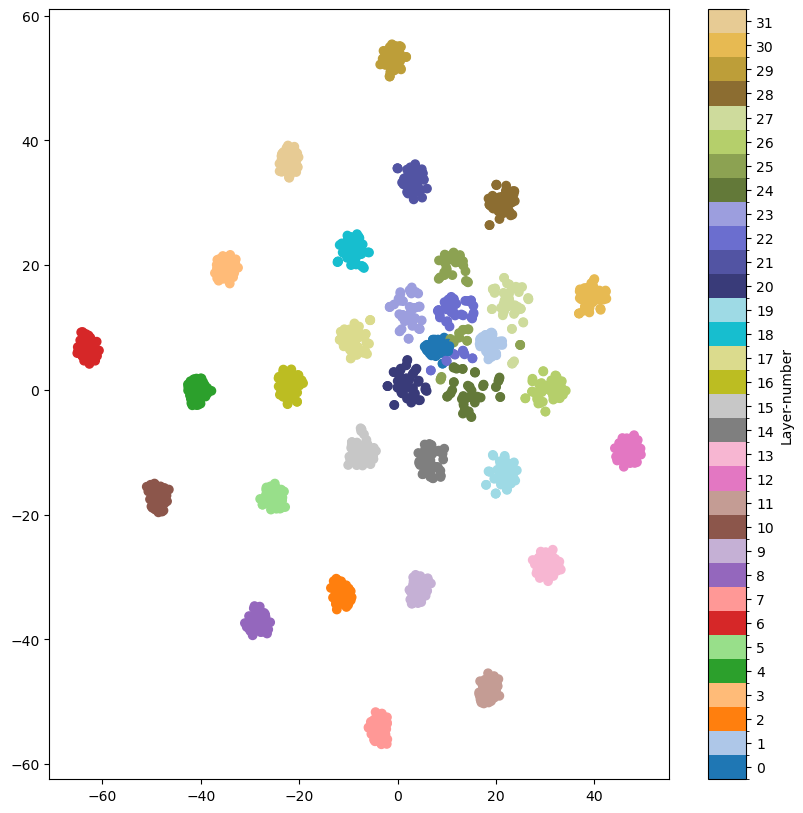

In [42]:
icvs = []

N_ITER = 50
for _ in range(N_ITER):
    icv = get_diff_stacked_hidden_states(train_dataset=train_dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=100, N_TRIALS=1, prefixes=prefixes, separators=separators, insert_inst=False)
    icvs.append(icv)

divide_by_layer = torch.cat([l.unsqueeze(1) for l in icvs], dim=1)
results_cosine = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='cosine')
results_euclidean = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='euclidean')
plot_normalized_density_results(results_cosine)
plot_normalized_density_results(results_euclidean)

icvs = torch.cat(icvs, dim=0)
icv_labels_by_layer = torch.tensor([i for i in range(32)]*N_ITER)

dim_reduction = TSNE(n_components=2, random_state=42)
icv_2d = dim_reduction.fit_transform(icvs)

plt.figure(figsize=(10, 10))
c = icv_labels_by_layer

colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
discrete_cmap = ListedColormap(colors[:32])
norm = BoundaryNorm(np.arange(-0.5, 32.5, 1), discrete_cmap.N)

scatter = plt.scatter(icv_2d[:, 0], icv_2d[:, 1], c=c, cmap=discrete_cmap, norm=norm)
cbar = plt.colorbar(scatter)
cbar.set_label('Layer-number')  # colorbar 제목
cbar.set_ticks(range(0, 32))  # 0부터 31까지 눈금 추가
cbar.set_ticklabels(range(0, 32))

plt.show()

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


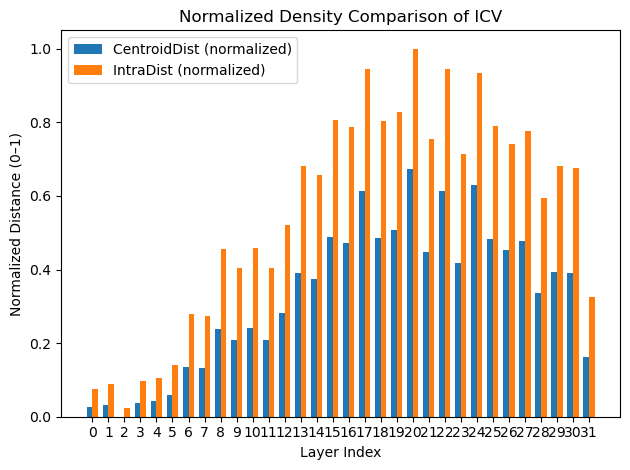

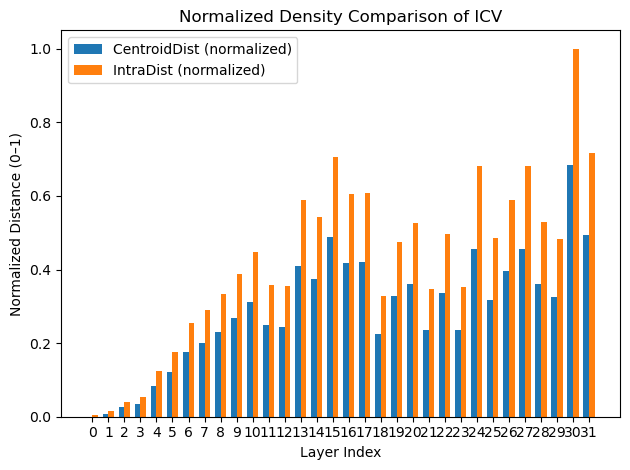

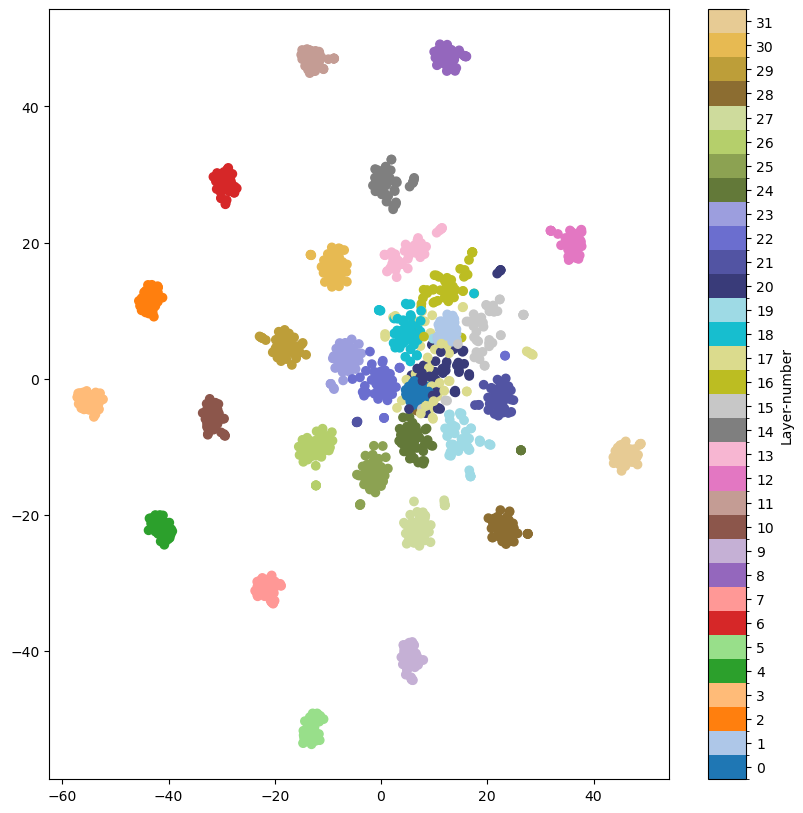

In [36]:
icvs = []

N_ITER = 50
for _ in range(N_ITER):
    icv = get_diff_stacked_hidden_states(train_dataset=train_dataset, model=model, model_config=model_config, tokenizer=tokenizer, n_icl_examples=100, N_TRIALS=1, prefixes=prefixes, separators=separators, insert_inst=True)
    icvs.append(icv)

divide_by_layer = torch.cat([l.unsqueeze(1) for l in icvs], dim=1)
results_cosine = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='cosine')
results_euclidean = analyze_vector_sets(torch.cat([l.unsqueeze(1) for l in icvs], dim=1).numpy(), metric='euclidean')
plot_normalized_density_results(results_cosine)
plot_normalized_density_results(results_euclidean)

icvs = torch.cat(icvs, dim=0)
icv_labels_by_layer = torch.tensor([i for i in range(32)]*N_ITER)

dim_reduction = TSNE(n_components=2, random_state=42)
icv_2d = dim_reduction.fit_transform(icvs)

plt.figure(figsize=(10, 10))
c = icv_labels_by_layer

colors = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
discrete_cmap = ListedColormap(colors[:32])
norm = BoundaryNorm(np.arange(-0.5, 32.5, 1), discrete_cmap.N)

scatter = plt.scatter(icv_2d[:, 0], icv_2d[:, 1], c=c, cmap=discrete_cmap, norm=norm)
cbar = plt.colorbar(scatter)
cbar.set_label('Layer-number')  # colorbar 제목
cbar.set_ticks(range(0, 32))  # 0부터 31까지 눈금 추가
cbar.set_ticklabels(range(0, 32))

plt.show()